# CS421: Introduction to ML
## Team: G2T4
### Project: Predicting Credit Card Customer Churn from Spending Behaviours & Background
### Data Preprocessing
---

# 1. Setting up the notebook
---
### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.model_selection import train_test_split

### Import dataset and tidy columns

In [2]:
data = pd.read_csv("./Data/BankChurners.csv")

In [3]:
data = data.drop(columns=["CLIENTNUM", "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1", "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2"], axis=1)
data.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [4]:
# tidy up and standardise column naming convention
tidied_cols = []
for col_name in data.columns:
    col_name = col_name.lower()
    if '_ct' in col_name:
        col_name = col_name.replace('_ct', '_count')
    if '_chng' in col_name:
        col_name = col_name.replace('_chng', '_change')
    tidied_cols.append( col_name )

data.columns = tidied_cols.copy()
data.columns

Index(['attrition_flag', 'customer_age', 'gender', 'dependent_count',
       'education_level', 'marital_status', 'income_category', 'card_category',
       'months_on_book', 'total_relationship_count', 'months_inactive_12_mon',
       'contacts_count_12_mon', 'credit_limit', 'total_revolving_bal',
       'avg_open_to_buy', 'total_amt_change_q4_q1', 'total_trans_amt',
       'total_trans_count', 'total_count_change_q4_q1',
       'avg_utilization_ratio'],
      dtype='object')

In [5]:
# retrieve categorical and numerical columns
numerical = list(data.describe().columns)
categorical = [i for i in data.columns if i not in numerical and i != "attrition_flag"]

### Splitting the data into train and test splits

In [6]:
y = data[["attrition_flag"]]
x = data.drop("attrition_flag", axis=1)
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_age              10127 non-null  int64  
 1   gender                    10127 non-null  object 
 2   dependent_count           10127 non-null  int64  
 3   education_level           10127 non-null  object 
 4   marital_status            10127 non-null  object 
 5   income_category           10127 non-null  object 
 6   card_category             10127 non-null  object 
 7   months_on_book            10127 non-null  int64  
 8   total_relationship_count  10127 non-null  int64  
 9   months_inactive_12_mon    10127 non-null  int64  
 10  contacts_count_12_mon     10127 non-null  int64  
 11  credit_limit              10127 non-null  float64
 12  total_revolving_bal       10127 non-null  int64  
 13  avg_open_to_buy           10127 non-null  float64
 14  total_

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y, random_state = 2021)

# 2. Data Cleaning
---

### Impute unknown values

In [8]:
def impute_unknown(df_x):
    """
        Imputes unknown values with their mode
    """
    x = df_x.copy()

    marital_status_mode = x["marital_status"].mode()[0]
    x["marital_status"] = x["marital_status"].replace("Unknown", marital_status_mode)
    education_level_mode = x["education_level"].mode()[0]
    x["education_level"] = x["education_level"].replace("Unknown", education_level_mode)
    income_category_mode = x["income_category"].mode()[0]
    x["income_category"] = x["income_category"].replace("Unknown", income_category_mode)
    
    return x

In [9]:
x_train = impute_unknown(x_train)
x_test = impute_unknown(x_test)

# 3. Feature Engineering
---

In [10]:
def feature_engineering(df_x, df_y):
    """
        Encoding categorical columns
    """
    x = df_x.copy()
    y = df_y.copy()
    
    # Binary Encoding — features with binary categories  
    attrition_mapper = {"Existing Customer":0, "Attrited Customer":1}
    y["attrition_flag"] = y["attrition_flag"].replace(attrition_mapper)
    
    gender_mapper = {"F":0, "M":1}
    x["gender"] = x["gender"].replace(gender_mapper)
    
    # One Hot Encoding — features with nominal categories
    onehot_enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
    values = onehot_enc.fit_transform(x[["marital_status"]])
    labels = np.array(["divorced", "married", "single"]).ravel()
    marital_status_df = pd.DataFrame(values, columns=labels)

    x.reset_index(drop=True, inplace=True)
    marital_status_df.reset_index(drop=True, inplace=True)
    x = pd.concat([x, marital_status_df], axis=1)
    x.drop("marital_status", axis=1, inplace=True)
    
    # Ordinal Encoding — features with ordinal categories
    edu_level_mapper = {"Doctorate":1, "Post-Graduate":2, "Graduate":3, "College":4, "High School":5, "Uneducated":6}
    x["education_level"] = x["education_level"].replace(edu_level_mapper)

    income_cat_mapper = {"$120K +":1, "$80K - $120K":2, "$60K - $80K":3, "$40K - $60K":4, "Less than $40K":5}
    x["income_category"] = x["income_category"].replace(income_cat_mapper)

    card_cat_mapper = {"Platinum":1, "Gold":2, "Silver":3, "Blue":4}
    x["card_category"] = x["card_category"].replace(card_cat_mapper)
    
    return x, y

In [11]:
x_train, y_train = feature_engineering(x_train, y_train)
x_test, y_test = feature_engineering(x_test, y_test)

# 4. Feature Selection
---

To reduce the dimensional space of the dataset, we are carrying out several feature selection techniques with the goal of identify features to keep and drop

1. Filter Methods
    - Chi-square
    - ANOVA
2. Embedded Methods
    - Random Forest
    - XGBoost
    - Lasso Regression  

In [12]:
def retrieve_feature_importance(importance, names):
    """
        Helper function to display the feature importance
    """
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data = {'feature_name':feature_names,'feature_importance':feature_importance}
    feature_importance_df = pd.DataFrame(data)

    feature_importance_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    return feature_importance_df.reset_index(drop=True)

## 4.1 Filter Methods
---
### Chi-square

- H0: 2 variables are independent (feature and target)
- H1: 2 variables are not independent
- 5% significance level, using p-value
- Reject H0 if p-value < 0.05

#### Conclusion: Drop `education_level`, `card_category`, `marital_status`, `income_category`

In [13]:
label_enc = LabelEncoder()
df_cat = data.copy()[categorical]

for cat in categorical:
    df_cat[cat] = label_enc.fit_transform(df_cat[cat])
    
y = data["attrition_flag"]
x = df_cat

,feature_name,p-value
0,education_level,0.560273
1,card_category,0.320692
2,marital_status,0.253711
3,income_category,0.115657
4,gender,0.006368


<AxesSubplot:>

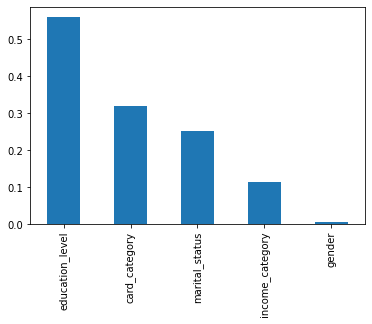

In [14]:
chi_scores = chi2(x, y)

# show results — dataframe
results_df = retrieve_feature_importance(chi_scores[1], x.columns)
results_df.rename(columns={"feature_importance": "p-value"}, inplace=True)
display(results_df)

# show results — graph
p_values = pd.Series(chi_scores[1], index = x.columns)
p_values.sort_values(ascending = False , inplace = True)
p_values.plot.bar()

### ANOVA

- H0: The numerical column cannot clearly discriminate between the 2 classes
- H1: The numerical column can clearly discriminate between the 2 classes
- 5% significance level, using F-Score
- F-value at 0.05 significance = 3.179
- Reject H0 if f-score > 3.179

#### Conclusion: Drop `months_on_book`, `avg_open_to_buy`

,feature_name,f-score
0,total_trans_count,1620.121692
1,total_count_change_q4_q1,930.078416
2,total_revolving_bal,752.702408
3,contacts_count_12_mon,441.868050
4,avg_utilization_ratio,332.876795
5,total_trans_amt,296.227714
6,months_inactive_12_mon,240.910376
7,total_relationship_count,233.072886
8,total_amt_change_q4_q1,176.961638
9,credit_limit,5.773729


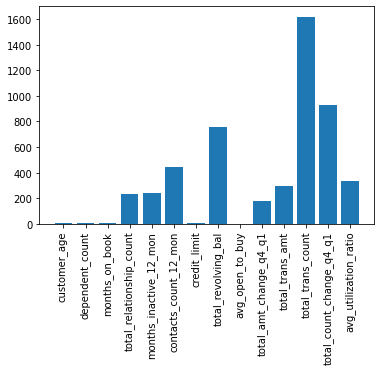

In [15]:
x = data.copy()[numerical]
fscore = SelectKBest(k="all")
fscore.fit(x, y)
x_fs = fscore.transform(x)

results_df = retrieve_feature_importance(fscore.scores_, x.columns)
results_df.rename(columns={"feature_importance": "f-score"}, inplace=True)
display(results_df)

plt.bar(numerical, fscore.scores_)
plt.xticks(rotation=90)

plt.show()

## 4.2 Embedded Methods
---

### 4.2.1 RandomForestClassifier

In [16]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=1000, random_state=2021)
rf_clf.fit(x_train, y_train.values.ravel() )

RandomForestClassifier(n_estimators=1000, random_state=2021)

In [17]:
feat_impt_df = retrieve_feature_importance(rf_clf.feature_importances_, x_train.columns)
feat_impt_df

,feature_name,feature_importance
0,total_trans_amt,0.188308
1,total_trans_count,0.163524
2,total_count_change_q4_q1,0.113568
3,total_revolving_bal,0.107599
4,avg_utilization_ratio,0.062619
5,total_amt_change_q4_q1,0.062213
6,total_relationship_count,0.061380
7,customer_age,0.034274
8,credit_limit,0.034231
9,avg_open_to_buy,0.032093


### 4.2.3 Lasso Regression

In [18]:
from sklearn.linear_model import Lasso

alpha_param = [1e-4, 1e-3, 1e-2, 1e-1, 1]

for alpha in alpha_param:
    lasso = Lasso(alpha=alpha)
    lasso.fit(x_train, y_train)

    importance = np.abs( lasso.coef_ )

    feat_impt_df = retrieve_feature_importance(importance, x_train.columns)
    feat_impt_df.index.rename('alpha='+str(alpha), inplace=True) 
    print( feat_impt_df )
    print()

                          feature_name  feature_importance
alpha=0.0001                                              
0             total_count_change_q4_q1        2.959714e-01
1                               gender        8.812127e-02
2               total_amt_change_q4_q1        4.513658e-02
3               months_inactive_12_mon        4.109820e-02
4             total_relationship_count        4.092733e-02
5                contacts_count_12_mon        4.002014e-02
6                              married        3.516924e-02
7                        card_category        3.398110e-02
8                avg_utilization_ratio        1.728211e-02
9                      income_category        1.536012e-02
10                     dependent_count        1.263369e-02
11                   total_trans_count        1.014859e-02
12                              single        4.911619e-03
13                     education_level        4.029209e-03
14                      months_on_book        5.286513e-

### 4.2.4 XGBoost

In [19]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False,
                    random_state=2021)
                    
xgb.fit(x_train, y_train)

[14:56:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              random_state=2021, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [20]:
feat_impt_df = retrieve_feature_importance(xgb.feature_importances_, x_train.columns)
feat_impt_df

,feature_name,feature_importance
0,total_trans_count,0.218843
1,total_revolving_bal,0.192140
2,total_relationship_count,0.121285
3,total_trans_amt,0.066119
4,total_count_change_q4_q1,0.052782
5,months_inactive_12_mon,0.051975
6,customer_age,0.041091
7,total_amt_change_q4_q1,0.032318
8,contacts_count_12_mon,0.029804
9,gender,0.029795


### Conclusion:
Results from the Feature Selection process are consolidated into this Google Sheet: https://docs.google.com/spreadsheets/d/1RnqAYQ1_cuOXaPCVTZo1uLN60a0qwHwB2qZ8l3BlKa8/edit?usp=sharing

In [21]:
x_train.drop(["income_category", "single", "divorced", "married", "avg_open_to_buy", "customer_age", "months_on_book", "card_category", "education_level", "total_trans_count"], axis=1, inplace=True)
x_test.drop(["income_category", "single", "divorced", "married", "avg_open_to_buy", "customer_age", "months_on_book", "card_category", "education_level", "total_trans_count"], axis=1, inplace=True)

# 5. Feature Transformation

In [22]:
def transformation(df_x):
    x = df_x.copy()
    
    # Feature Transformation — Log Transformation for skewed data
    skewed = ["credit_limit", "total_amt_change_q4_q1", "total_trans_amt", "total_count_change_q4_q1"]

    for skewed_col in skewed:
        x[skewed_col] = np.log(x[skewed_col].mask(x[skewed_col] <=0)).fillna(0)
    
    return x

x_train = transformation(x_train)
x_test = transformation(x_test)

# 6. Exporting preprocessed Train Test sets to csv files

In [34]:
x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
train = pd.concat([x_train, y_train], axis=1)

x_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
test = pd.concat([x_test, y_test], axis=1)

try:
    train.to_csv("./data/train.csv", index=False)
    test.to_csv("./data/test.csv", index=False)
    print('Succesfully exported')
except:
    print('Error')

Succesfully exported
